# Generating Handwritten Digits with DCGAN

Deep Convolutional Generative Adversarial Network ([DCGAN](https://arxiv.org/pdf/1511.06434.pdf)).

## What are GANs?
Generative Adversarial Networks (GANs) are a framework for estimating generative models. Two models are trained simultaneously by an adversarial process: a Generator, which is responsible for generating images, and a Discriminator, which is responsible for estimating the probability that an image was drawn from the training data (the image is real), or was produced by the Generator (the image is fake). During training, the Generator becomes progressively better at generating images, until the Discriminator is no longer able to distinguish real images from fake. 

![alt text](https://github.com/margaretmz/tensorflow/blob/margaret-dcgan/tensorflow/contrib/eager/python/examples/generative_examples/gans_diagram.png?raw=1)

We will demonstrate this process end-to-end on MNIST. Below is an animation that shows a series of images produced by the Generator as it was trained for 50 epochs. Overtime, the generated images become increasingly difficult to distinguish from the training set.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

### Import Keras

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Load the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [2]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5
X_train.shape

(60000, 28, 28, 1)

## Create the models

The discriminator and the generator optimizers are different since we will train two networks separately.

### The Generator Model

The generator is responsible for creating convincing images that are good enough to fool the discriminator. The network architecture for the generator consists of Conv2DTranspose (Upsampling) layers. We start with a fully connected layer and upsample the image two times in order to reach the desired image size of 28x28x1. We increase the width and height, and reduce the depth as we move through the layers in the network. We use Leaky ReLU activation for each layer except for the last one where we use a tanh activation.

In [3]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
  
  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)  
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)    
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

### The Discriminator model

The discriminator is responsible for distinguishing fake images from real images. It's similar to a regular CNN-based image classifier.

In [73]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=(28,28,1)))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Flatten())
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', metrics=['accuracy'])
  return model

## Set up GANs for Training



Now it's time to put together the generator and discriminator to set up the Generative Adversarial Networks, as you see in the diagam at the beginning of the tutorial.

Get the output of the generator and then feed it to the discriminator ( D(G(input)) ).

In [74]:
generator = build_generator()
discriminator = build_discriminator()

gan = Sequential([generator,discriminator])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy')

**Define training method**

We start by iterating over the dataset. The generator is given a random vector as an input which is processed to output an image looking like a handwritten digit. The discriminator is then shown the real MNIST images as well as the generated images.

## Generated images 


In [82]:
n_epoch = 100
batch_size = 512
batch_count = X_train.shape[0] // batch_size
d_losses = []
g_losses = []
for i in range(n_epoch):
  for j in tqdm(range(batch_count)):
    # Input for the generator
    noise_input = np.random.rand(batch_size, 100)
    
    # getting random images from X_train of size=batch_size
    # these are the real images that will be fed to the discriminator
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
    
    # these are the predicted images from the generator
    predictions = generator.predict(noise_input, batch_size=batch_size)
    
    # the discriminator takes in the real images and the generated images
    X = np.concatenate([predictions, image_batch])
    X = tf.convert_to_tensor(X,dtype=tf.float32)
    # labels for the discriminator
    y_discriminator = np.array([0]*batch_size + [1]*batch_size)
    
    # Let's train the discriminator
    discriminator.trainable = True
    loss = discriminator.train_on_batch(X, y_discriminator)
    d_losses.append(loss)
    # Let's train the generator
    noise_input = np.random.rand(batch_size, 100)
    y_generator = np.array([1]*batch_size)
    discriminator.trainable = False
    loss = gan.train_on_batch(noise_input, y_generator)
    g_losses.append(loss)

100%|██████████| 117/117 [00:16<00:00,  7.16it/s]



After training, its time to generate some images! 
The last step is to plot the generated images and voila!


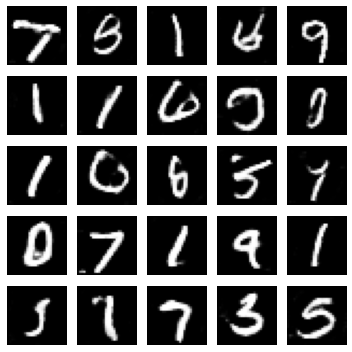

In [88]:
try_input = np.random.rand(25, 100)
preds = generator.predict(try_input)
plt.figure(figsize=(5,5))
for i in range(preds.shape[0]):
  plt.subplot(5, 5, i+1)
  plt.imshow(preds[i, :, :, 0], cmap='gray')
  plt.axis('off')
  plt.tight_layout()